# Steel Defects Classification

In this section we will build a multi-class classifier to classify the type steel defect shown on an image. To mitigate the class-imbalance, during training we will augment the images and for every batch augmented we will over sample the minority classes to have better representation. To evaluate the performance of the model, we expecct the precision, recall and f1 scores to be similar. 

In [15]:
# main libraries
import numpy as np

# dataset
from steel_defects import steel_defects

# model
from defects_classifier import defects_classifier

# batch generator over sampler
from BalancedDataGenerator import BalancedDataGenerator

# image generator
from keras.preprocessing.image import ImageDataGenerator

# model training helpers
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

np.random.seed(42)

## Load Steel Defects Dataset

The images are preprocessed into a shape of 64 by 64 to gray scale, as a way to reduce the number of features. Noticed when each dataset is loaded into memory it also shows the number of each class. Class number 3 has approximately 75 percent of the whole dataset. In other owrds, just by predicting class 3 the model can acheive an accuracy of 75 percent. Therefore, we need the model to generalize among each class as much as possible.

In [2]:
steel = steel_defects()

In [3]:
trn_dir = '~./imgs_multiClass/train'
tst_dir = '~./imgs_multiClass/test'
val_dir = '~/imgs_multiClass/valid'

In [4]:
# training data
tr_imgs, tr_lbls = steel.load_defects(trn_dir)

100%|██████████| 422/422 [00:01<00:00, 264.95it/s]


In [5]:
# validation data
vl_imgs, vl_lbls = steel.load_defects(val_dir)

100%|██████████| 42/42 [00:00<00:00, 258.71it/s]


In [6]:
# testing data
ts_imgs, ts_lbls = steel.load_defects(tst_dir)

100%|██████████| 52/52 [00:00<00:00, 262.72it/s]


## Data Preparation

To reduce the memory foot-print, to train the model we will use an image generator from keras. As mentioned above, an additional piece of code was added to balance the image generated during training. To reduce the number of features each image was pre-processed to have only one color channel, gray scale. To augment the training data, the image generator will flip the image horizontally and vertically, and also tweek the brightness from a range of 02. to 0.8. To ensure reproducibility, the random number generator was seeded at 42.

In [7]:
tr_generator = ImageDataGenerator(rescale=1.0/255, 
                                  brightness_range=(0.2, 0.8), 
                                  horizontal_flip=True, 
                                  vertical_flip=True)

ts_generator = ImageDataGenerator(rescale=1.0/255)

ts_gen = ts_generator.flow(ts_imgs, ts_lbls, batch_size=32, seed=42)
vl_gen = ts_generator.flow(vl_imgs, vl_lbls, batch_size=32, seed=42)

bgen = BalancedDataGenerator(tr_imgs, tr_lbls, tr_generator, batch_size=32)

print('Number of steps per epoch {}'.format(bgen.steps_per_epoch))

Number of steps per epoch 481


## Model Training and Evaluation

To reduce overfiting due to the class imbalance, the model was created with several droputs. After the first convolutional layer we used a bacth normalization layer which improved the learning of the algorithm. The folowing layers are two blocks of convolution, 10 percent spatial dropout and max-pooling layer, then another convolution and a max-pool layer. The classifier has a ten pecent dropout with 512 neurons in the first dense layer and 4 neurons in the output layer. This model architecture gives a total of 5,109,060 trainable parameters. Due the image data generator will act randomly, to enhance the learning and avoid learning cycles the optimizer used is stochastic gradient descent. The loss function is categorical entropy and the target metrics is accuracy.

In [8]:
model_classifier = defects_classifier.make_model()

In [9]:
model_classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)      

Training convolutional models takes time and sometimes after a few epochs it can start overfiting. One strategy we used was to record the best weights after every epcoh based on the accuracy of the validation. Additonally we added early stopping and reduce plateau to monitor the model's learning and stop the process when the model has already learned enough.

In [10]:
call_list = [
    ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=0, factor=0.04, min_lr=0.001),
    EarlyStopping(monitor='val_accuracy', patience=5), 
    ModelCheckpoint(filepath='./logs/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5', 
                    save_weights_only=True, 
                    save_best_only=True, 
                    monitor='val_accuracy', 
                    mode='max', 
                    verbose=0)
]

In [11]:
np.random.seed(42)

history = model_classifier.fit_generator(bgen, 
                                           steps_per_epoch=481,
                                           validation_data=vl_gen,
                                           validation_steps=len(vl_imgs)//32,
                                           epochs=50,
                                           callbacks=call_list)

Epoch 1/50
481/481 [==============================] - 87s 180ms/step - loss: 1.1103 - accuracy: 0.5015 - val_loss: 1.0483 - val_accuracy: 0.6287
Epoch 2/50
481/481 [==============================] - 93s 193ms/step - loss: 0.9238 - accuracy: 0.6081 - val_loss: 0.9293 - val_accuracy: 0.5763
Epoch 3/50
481/481 [==============================] - 94s 196ms/step - loss: 0.8658 - accuracy: 0.6363 - val_loss: 0.7264 - val_accuracy: 0.6279
Epoch 4/50
481/481 [==============================] - 96s 200ms/step - loss: 0.8254 - accuracy: 0.6564 - val_loss: 0.8791 - val_accuracy: 0.5611
Epoch 5/50
481/481 [==============================] - 96s 200ms/step - loss: 0.7860 - accuracy: 0.6743 - val_loss: 0.7446 - val_accuracy: 0.6775
Epoch 6/50
481/481 [==============================] - 97s 201ms/step - loss: 0.7515 - accuracy: 0.6895 - val_loss: 0.9353 - val_accuracy: 0.6317
Epoch 7/50
481/481 [==============================] - 96s 199ms/step - loss: 0.7139 - accuracy: 0.7102 - val_loss: 0.6210 - val_ac

In [57]:
model_classifier.save('nultiClass_defects.h5')

In [12]:
plots = defects_classifier()

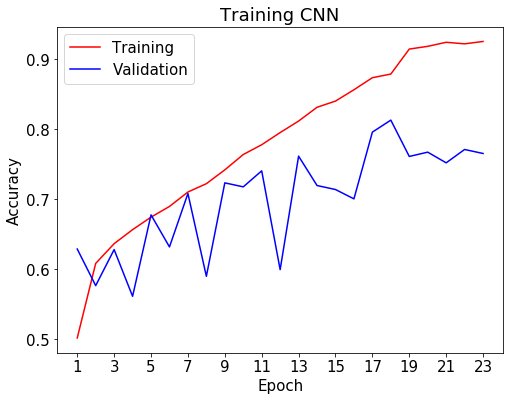

In [45]:
plots.plot_accuracy(history=history, title='Training CNN', x_width=2, label_size=15, save=True)

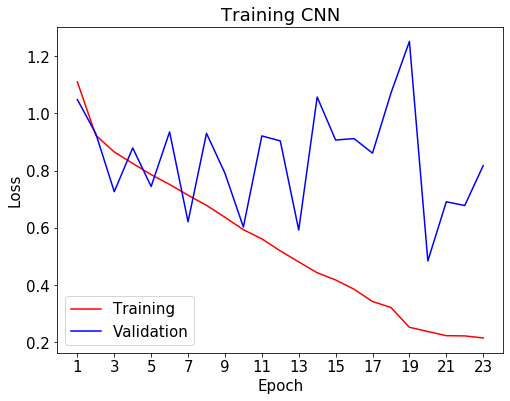

In [46]:
plots.plot_loss(history=history, title='Training CNN', x_width=2, label_size=15, save=True)

Initially for every epcoh the the accuracy of the validation increased while its loss was not stable. After 20 epochs the accuracy of the training and validation plateaus out but the loss in the validation does not show a significant change as in the training set. This trend in training and the confusion matrix and classification report of the trained model shows the model does generalize for class 1, 2 and 3 but it is enable to propeerly classify class 4.  

In [24]:
defects = defects_classifier()

In [25]:
defects.cl_report(model_classifier, tr_imgs, tr_lbls, 'Training')

Training

Confusion Matrix

[[ 438    2  166   24]
 [   8  110   24   15]
 [ 196   26 3492  136]
 [   6    0  260  156]]

Classification Report

              precision    recall  f1-score   support

           0       0.68      0.70      0.69       630
           1       0.80      0.70      0.75       157
           2       0.89      0.91      0.90      3850
           3       0.47      0.37      0.41       422

    accuracy                           0.83      5059
   macro avg       0.71      0.67      0.69      5059
weighted avg       0.82      0.83      0.83      5059



In [27]:
defects.cl_report(model_classifier, vl_imgs, vl_lbls, 'Validation')

Validation

Confusion Matrix

[[ 29   2  28   3]
 [  0   9   6   4]
 [ 37   7 368  21]
 [  1   0  37   4]]

Classification Report

              precision    recall  f1-score   support

           0       0.43      0.47      0.45        62
           1       0.50      0.47      0.49        19
           2       0.84      0.85      0.84       433
           3       0.12      0.10      0.11        42

    accuracy                           0.74       556
   macro avg       0.47      0.47      0.47       556
weighted avg       0.73      0.74      0.73       556



### Loaded weights

In this section we will check the performance of the best saved weights during training. Specifically we will at the weights of epoch number 7 and 18. 

In [49]:
model_7 = defects_classifier.make_model()

In [50]:
model_7.load_weights('./logs/weights-improvement-07-0.71.hdf5')

In [51]:
defects.cl_report(model_7, tr_imgs, tr_lbls, 'Training')

Training

Confusion Matrix

[[ 235    9  386    0]
 [  34   62   61    0]
 [ 256   36 3505   53]
 [  10    0  380   32]]

Classification Report

              precision    recall  f1-score   support

           0       0.44      0.37      0.40       630
           1       0.58      0.39      0.47       157
           2       0.81      0.91      0.86      3850
           3       0.38      0.08      0.13       422

    accuracy                           0.76      5059
   macro avg       0.55      0.44      0.46      5059
weighted avg       0.72      0.76      0.73      5059



In [52]:
defects.cl_report(model_7, vl_imgs, vl_lbls, 'Validation')

Validation

Confusion Matrix

[[ 20   2  40   0]
 [  5   8   6   0]
 [ 31   6 386  10]
 [  1   0  40   1]]

Classification Report

              precision    recall  f1-score   support

           0       0.35      0.32      0.34        62
           1       0.50      0.42      0.46        19
           2       0.82      0.89      0.85       433
           3       0.09      0.02      0.04        42

    accuracy                           0.75       556
   macro avg       0.44      0.41      0.42       556
weighted avg       0.70      0.75      0.72       556



The results from epcoh 7 suggests the model was basically predicting class 2 and 3 with class performing poorly. Same results are shown from the weights of epoch 8. Despite the final trained model overfits, it shows better results than these two. At least it can generalize more with class 1.

In [53]:
model_18 = defects_classifier.make_model()

In [54]:
model_18.load_weights('./logs/weights-improvement-18-0.81.hdf5')

In [55]:
defects.cl_report(model_18, tr_imgs, tr_lbls, 'Training')

Training

Confusion Matrix

[[ 359    5  255   11]
 [   7  105   39    6]
 [ 157   23 3615   55]
 [   3    0  347   72]]

Classification Report

              precision    recall  f1-score   support

           0       0.68      0.57      0.62       630
           1       0.79      0.67      0.72       157
           2       0.85      0.94      0.89      3850
           3       0.50      0.17      0.25       422

    accuracy                           0.82      5059
   macro avg       0.71      0.59      0.62      5059
weighted avg       0.80      0.82      0.80      5059



In [56]:
defects.cl_report(model_18, vl_imgs, vl_lbls, 'Validation')

Validation

Confusion Matrix

[[ 20   1  39   2]
 [  0  10   6   3]
 [ 25   6 391  11]
 [  1   0  40   1]]

Classification Report

              precision    recall  f1-score   support

           0       0.43      0.32      0.37        62
           1       0.59      0.53      0.56        19
           2       0.82      0.90      0.86       433
           3       0.06      0.02      0.03        42

    accuracy                           0.76       556
   macro avg       0.48      0.44      0.46       556
weighted avg       0.71      0.76      0.73       556



## Discussion

Training convolutional neural networks with a small unbalanced dataset is not an easy task. After implementing several strategies to produce a model, due to the given dataset, the model overfits. Ideally, a larger dataset with more class representation would do the work. Another option would be to try and drop class 4. this might decrease the overfit and improve the validation scores.